# loan-prediction-project
## Author: Amal Chebbi
Date : 01/22/2025

## Import Libraries

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Load Training Data

In [4]:
# Load the dataset
training_data_path = 'training_loan_data.csv'
train_data = pd.read_csv(training_data_path, header=None, encoding='latin1')

# Set the second row as column headers
train_data.columns = train_data.iloc[1]

# Drop the first two rows
train_data = train_data[2:].reset_index(drop=True)

train_data.head()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/var/folders/17/m9zbjm4x4x77jk_3503c2s700000gn/T/ipykernel_7382/1057500546.py:3: DtypeWarning: Columns (0,1,2,7,10,11,12,13,14,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(training_data_path, header=None, encoding='latin1')


1,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056,7550,36 months,16.24%,3 years,RENT,28000,NaN,debt_consolidation,...,0,17,72%,4000,NaN,3828.953801,5759,1,99,0
1,10000002,12002921,27050,36 months,10.99%,10+ years,OWN,55000,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,...,0,8,61.20%,35700,NaN,34359.94073,114834,1,353,0
2,10000003,11983096,12000,36 months,10.99%,4 years,RENT,60000,Borrower added on 12/31/13 > I would like to...,debt_consolidation,...,1,3,24%,18100,NaN,16416.61776,7137,1,157,0
3,10000004,12003142,28000,36 months,7.62%,5 years,MORTGAGE,325000,NaN,debt_consolidation,...,1,3,54.60%,42200,NaN,38014.14976,799592,1,365,0
4,10000005,11993233,12000,36 months,13.53%,10+ years,RENT,40000,NaN,debt_consolidation,...,0,17,68.80%,7000,53,6471.462236,13605,1,157,0


In [5]:
#shape of the training data
train_data.shape

(199121, 23)

In [6]:
# Inspect the dataset
print("Initial Dataset Info:")
train_data.info()

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   id                           199121 non-null  object
 1   member_id                    189457 non-null  object
 2   loan_amnt                    199121 non-null  object
 3   term                         189457 non-null  object
 4   int_rate                     189457 non-null  object
 5   emp_length                   181531 non-null  object
 6   home_ownership               189457 non-null  object
 7   annual_inc                   189457 non-null  object
 8   desc                         82004 non-null   object
 9   purpose                      189457 non-null  object
 10  percent_bc_gt_75             180419 non-null  object
 11  bc_util                      180333 non-null  object
 12  dti                          189457 non-null  obje

In [7]:
train_data['bad_flag'].unique()

array(['0', '1', 0, 1, nan], dtype=object)

In [8]:
# Clean 'bad_flag' column
train_data['bad_flag'] = pd.to_numeric(train_data['bad_flag'], errors='coerce')
print("Unique values in 'bad_flag' after cleaning:", train_data['bad_flag'].unique())

Unique values in 'bad_flag' after cleaning: [ 0.  1. nan]


In [9]:
def preprocess_data(df, is_test=False):
    """
    Cleans and preprocesses the dataset for modeling, addressing specific observations.
    
    Parameters:
        df (pd.DataFrame): The raw dataset to preprocess.
        is_test (bool): Flag indicating if the dataset is a test set (default: False).
    
    Returns:
        pd.DataFrame: The cleaned and preprocessed dataset.
    """
    # Drop unnecessary columns
    columns_to_drop = [
        'id', 'member_id', 'desc', 
        'mths_since_last_major_derog', 'application_approved_flag'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    # Clean and convert 'emp_length'
    def clean_emp_length(value):
        if pd.isnull(value) or value == "n/a":
            return np.nan
        elif "<" in value:
            return 0
        elif "10+" in value:
            return 10
        else:
            try:
                return int(value.split()[0])
            except:
                return np.nan

    if 'emp_length' in df.columns:
        df['emp_length'] = df['emp_length'].apply(clean_emp_length)
    
    # Clean and convert percentage columns
    columns_to_process = ['bc_util', 'revol_util', 'int_rate']
    for col in columns_to_process:
        if col in df.columns:
            df[col] = df[col].str.rstrip('%').astype(float, errors='ignore')

    # Convert 'mths_since_recent_inq' to numeric
    if 'mths_since_recent_inq' in df.columns:
        df['mths_since_recent_inq'] = pd.to_numeric(df['mths_since_recent_inq'], errors='coerce')

    # Convert numeric columns to float
    numeric_columns = [
        'loan_amnt', 'int_rate', 'annual_inc', 'dti', 
        'inq_last_6mths', 'bc_util', 'total_bc_limit',
        'tot_hi_cred_lim', 'tot_cur_bal', 'internal_score', 
        'percent_bc_gt_75', 'mths_since_recent_inq', 'revol_util'
    ]
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert categorical columns to 'category'
    categorical_columns = ['term', 'home_ownership', 'purpose']
    if not is_test:
        categorical_columns.append('bad_flag')  # Include the target column for training data
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    # Handle missing values
    # Numeric columns: Fill with median
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Categorical columns: Fill with "Unknown"
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].cat.add_categories("Unknown").fillna("Unknown")
    
    # Log preprocessing summary
    print("Preprocessing Summary:")
    print(f"Numeric Columns: {len(numeric_columns)} processed")
    print(f"Categorical Columns: {len(categorical_columns)} processed")
    print(f"Final Shape: {df.shape}")
    
    return df


In [10]:
# Apply preprocessing to training data
train_data_cleaned = preprocess_data(train_data)

# Display the cleaned data info
print("Cleaned Training Data Info:")
train_data_cleaned.info()

Preprocessing Summary:
Numeric Columns: 13 processed
Categorical Columns: 4 processed
Final Shape: (199121, 18)
Cleaned Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   loan_amnt              199121 non-null  int64   
 1   term                   199121 non-null  category
 2   int_rate               199121 non-null  float64 
 3   emp_length             181531 non-null  float64 
 4   home_ownership         199121 non-null  category
 5   annual_inc             199121 non-null  float64 
 6   purpose                199121 non-null  category
 7   percent_bc_gt_75       199121 non-null  float64 
 8   bc_util                199121 non-null  float64 
 9   dti                    199121 non-null  float64 
 10  inq_last_6mths         199121 non-null  float64 
 11  mths_since_recent_inq  199121 non-null  fl

# EDA:
- Examine the distribution of bad_flag to understand class balance.
- Numerical Feature Analysis:Check distributions and potential outliers.
- Analyze correlations between numerical features and bad_flag.
- Categorical Feature Analysis:
- Visualize the relationship between categorical features and bad_flag.

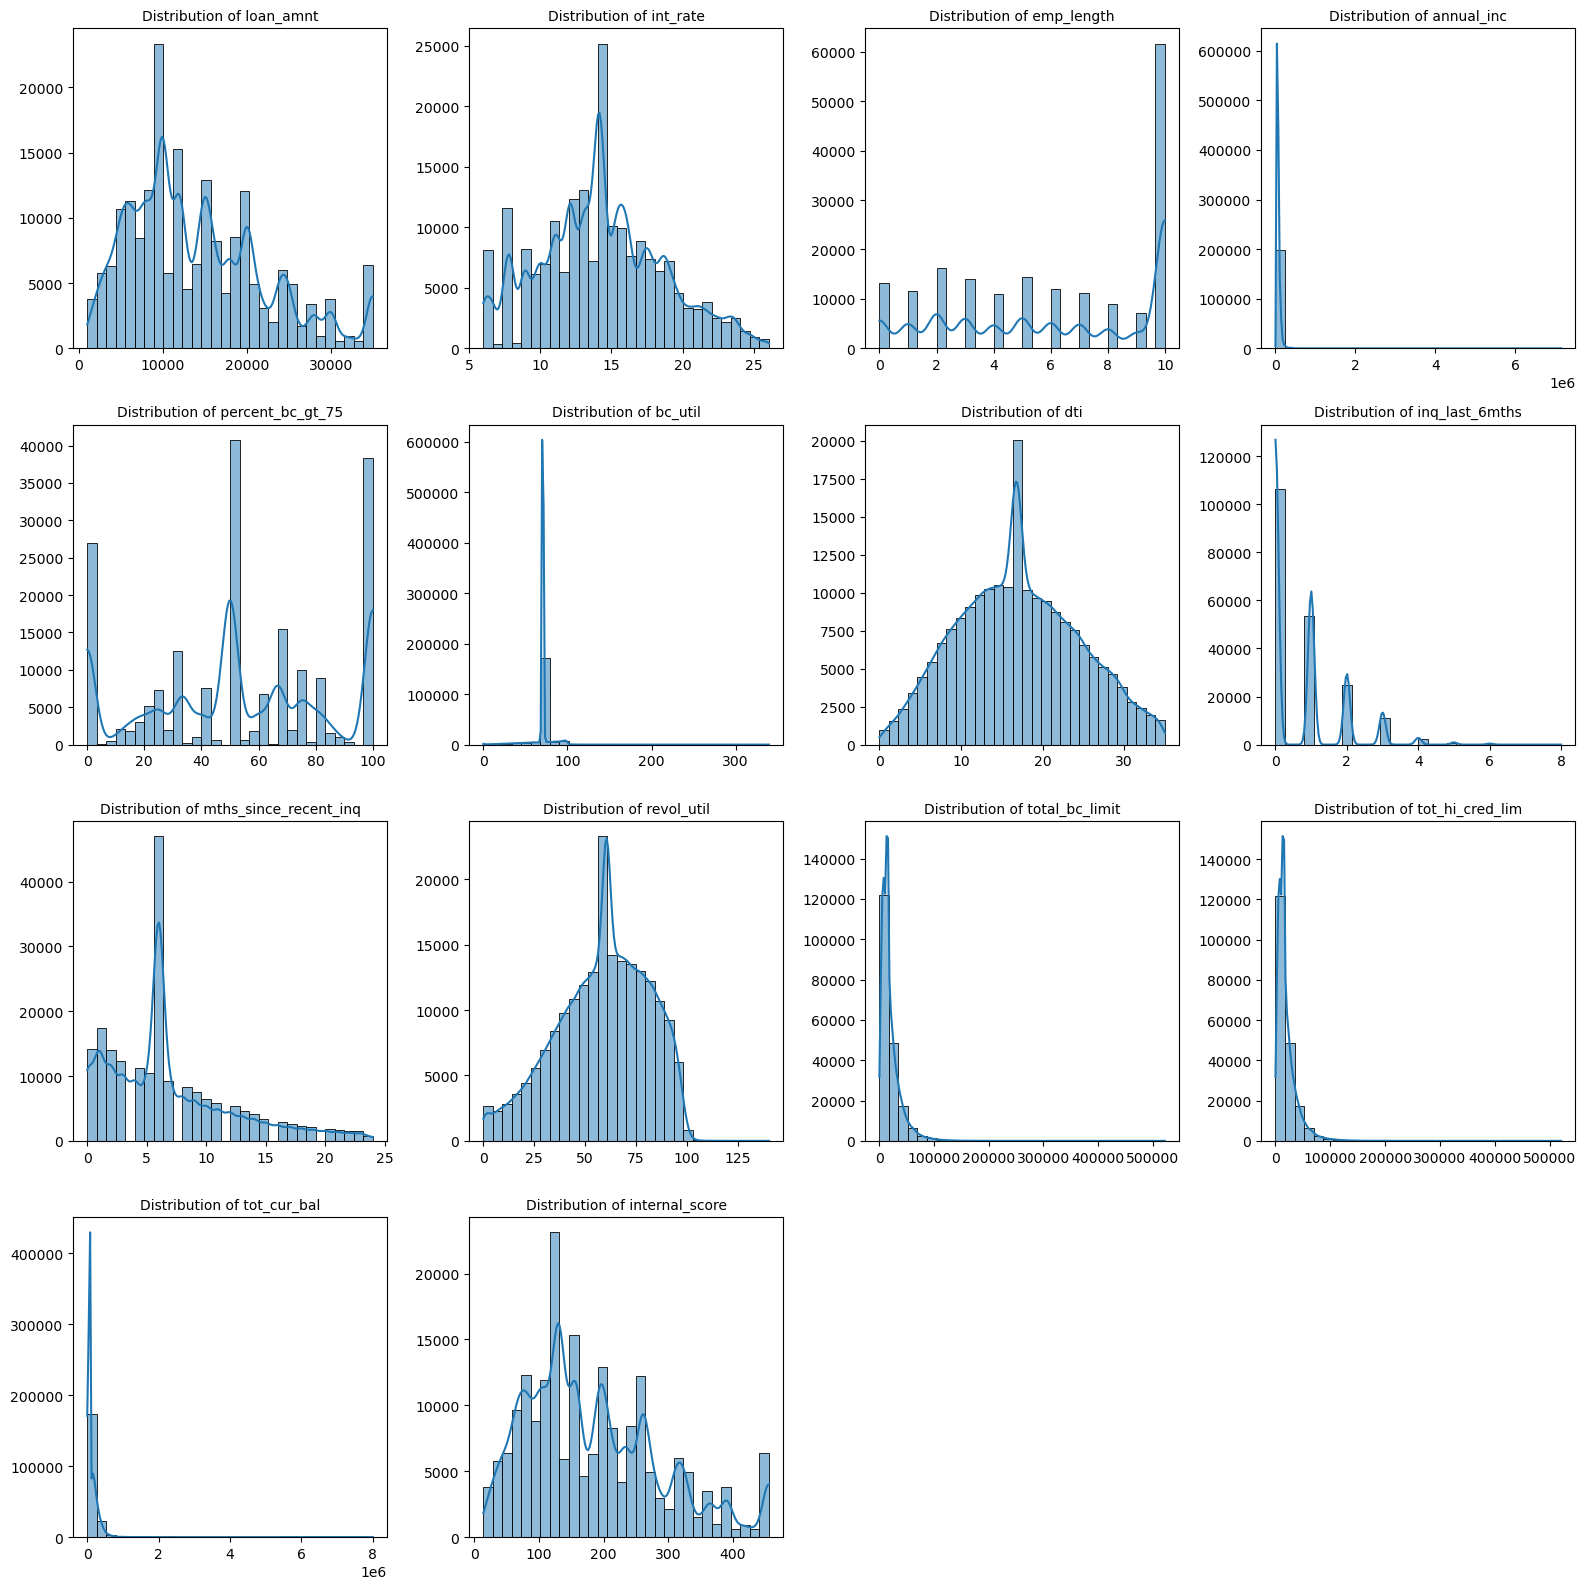

In [15]:
numeric_columns = train_data_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows for the grid layout
num_cols = len(numeric_columns)
num_rows = math.ceil(num_cols / 4)

# Plot distributions
plt.figure(figsize=(16, num_rows * 4))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.histplot(train_data_cleaned[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}", fontsize=10)
    plt.xlabel("")  # Remove xlabel for a cleaner look
    plt.ylabel("")  # Remove ylabel for a cleaner look
plt.tight_layout()
plt.show()

1. **Loan Amount Distribution**:  
   - The loan amounts are right-skewed, with most values concentrated below $15,000.

2. **Interest Rate Distribution**:  
   - The interest rates show a unimodal distribution, peaking between 10% and 20%.

3. **Employment Length Distribution**:  
   - The majority of borrowers have employment lengths of 10+ years.

4. **Annual Income Distribution**:  
   - The annual incomes are highly right-skewed, with a few extreme outliers.

5. **Percentage of Credit Balance > 75%**:  
   - A clear concentration around multiples of 25%, likely due to data rounding.

6. **Credit Utilization (bc_util)**:  
   - Skewed distribution with most values below 50%, though outliers exist.

7. **Debt-to-Income Ratio (DTI)**:  
   - Symmetrical distribution centered around 15-20, indicating moderate debt loads.

8. **Inquiries in Last 6 Months**:  
   - Most borrowers have few recent inquiries, typically 0–2.

9. **Revolving Utilization Rate**:  
   - Distribution peaks around 50%, with a gradual decline toward 100%.

10. **Total Bankcard Credit Limit**:  
    - Extremely right-skewed, with most values concentrated at lower ranges.

11. **Total High Credit Limit**:  
    - Similar to total bankcard credit limit, with pronounced right skewness.

12. **Current Total Balance**:  
    - Highly skewed, with a majority of borrowers having balances below $1 million.

13. **Internal Score Distribution**:  
    - A roughly normal distribution with a peak around 200.


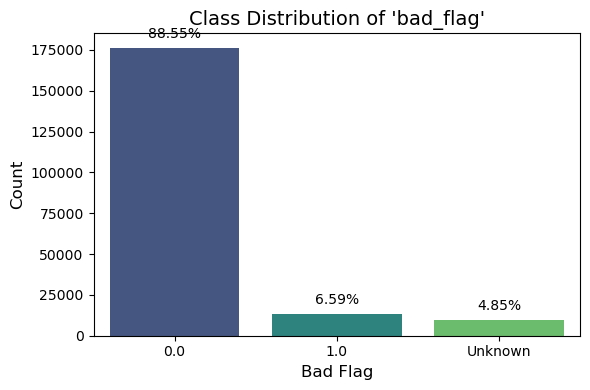

Class Counts:
 bad_flag
0.0        176329
1.0         13128
Unknown      9664
Name: count, dtype: int64
Class Percentages:
 bad_flag
0.0        88.553693
1.0         6.592976
Unknown     4.853330
Name: proportion, dtype: float64


In [16]:
plt.figure(figsize=(6, 4))

# Create a count plot with 'hue' matching 'x' and legend disabled
ax = sns.countplot(data=train_data_cleaned, x='bad_flag', hue='bad_flag', palette='viridis', legend=False)

# Add percentages on the bars
for p in ax.patches:
    percentage = f"{100 * p.get_height() / len(train_data_cleaned):.2f}%"
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add titles and labels
plt.title("Class Distribution of 'bad_flag'", fontsize=14)
plt.xlabel("Bad Flag", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Print class counts and percentages
class_counts = train_data_cleaned['bad_flag'].value_counts(normalize=False)
class_percentages = train_data_cleaned['bad_flag'].value_counts(normalize=True) * 100
print("Class Counts:\n", class_counts)
print("Class Percentages:\n", class_percentages)


**Class Distribution of 'bad_flag':**  
- The dataset is highly imbalanced, with **88.55% of samples labeled as 0.0 (good loans)**.  
- Only **6.59% of samples are labeled as 1.0 (bad loans)**.  
- **4.85% of samples are marked as "Unknown"**, which may need further cleaning or imputation.  
- Imbalance in the target variable may require techniques like resampling (oversampling/undersampling) or using algorithms that handle imbalance well (SMOTE).

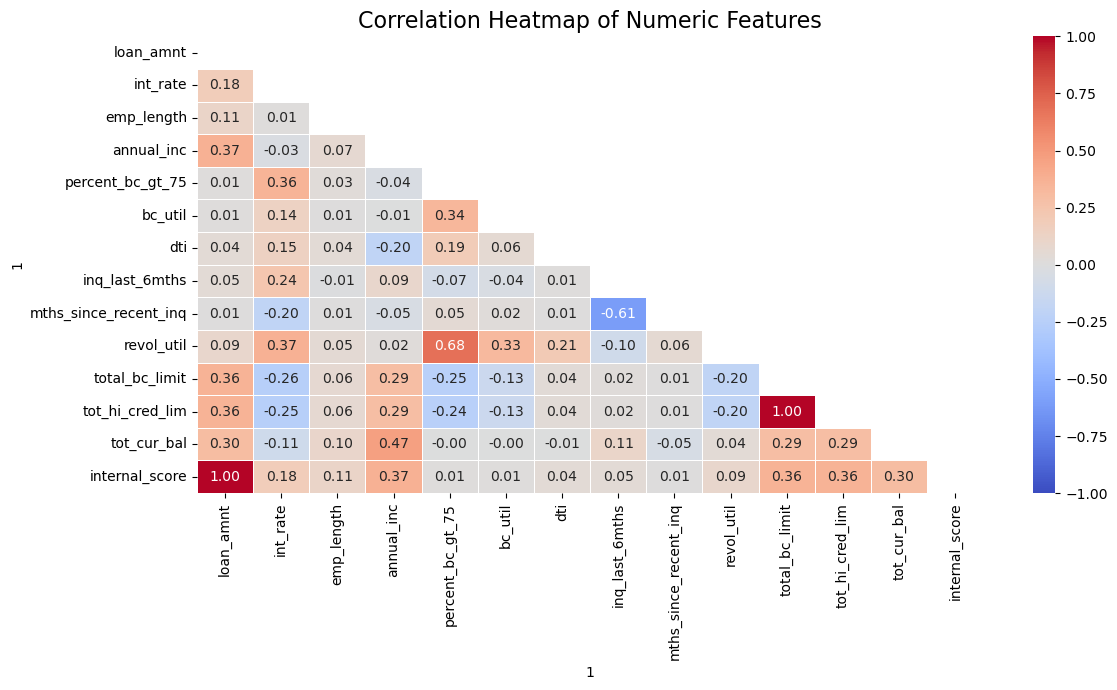

In [17]:
plt.figure(figsize=(12, 7))

# Calculate the correlation matrix
correlation_matrix = train_data_cleaned[numeric_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Draw the heatmap
sns.heatmap(
    correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
    vmin=-1, vmax=1, cbar=True, linewidths=0.5, annot_kws={"size": 10}
)

# Add title
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


**Correlation Heatmap of Numeric Features**:  
- The heatmap highlights the pairwise correlation between numeric features.  
- **Key Observations**:
  - **Strong Positive Correlations**:
    - `revol_util` and `bc_util` (0.68): Indicates a strong relationship between revolving credit utilization and bankcard utilization.
    - `total_bc_limit` and `tot_hi_cred_lim` (0.29): Suggests a relationship between credit limits.
  - **Moderate Correlations**:
    - `loan_amnt` correlates moderately with `annual_inc` (0.37) and `total_bc_limit` (0.36).
    - `tot_cur_bal` shows a moderate positive correlation with `total_bc_limit` (0.47).
  - **Negative Correlations**:
    - `mths_since_recent_inq` shows a moderate negative correlation with `bc_util` (-0.20), possibly reflecting credit-seeking behavior.
  - Most features exhibit weak or negligible correlations with one another, indicating a low degree of multicollinearity.

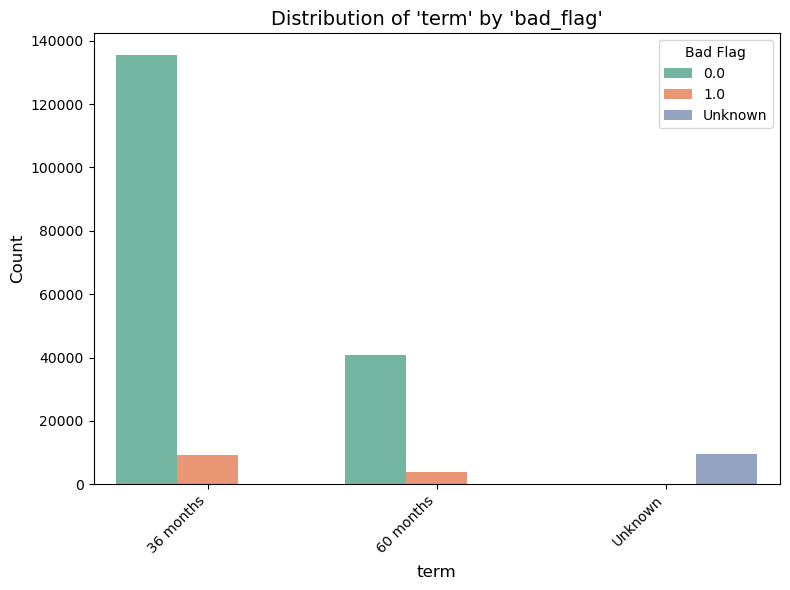

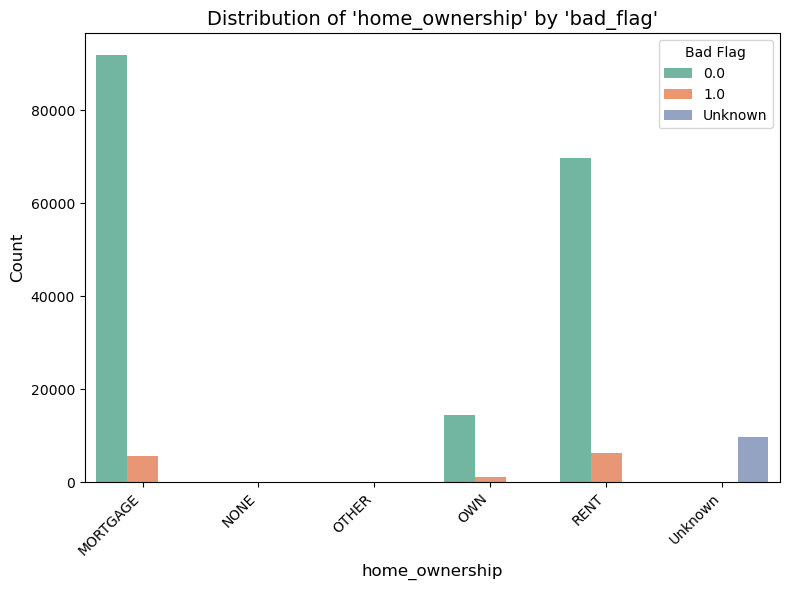

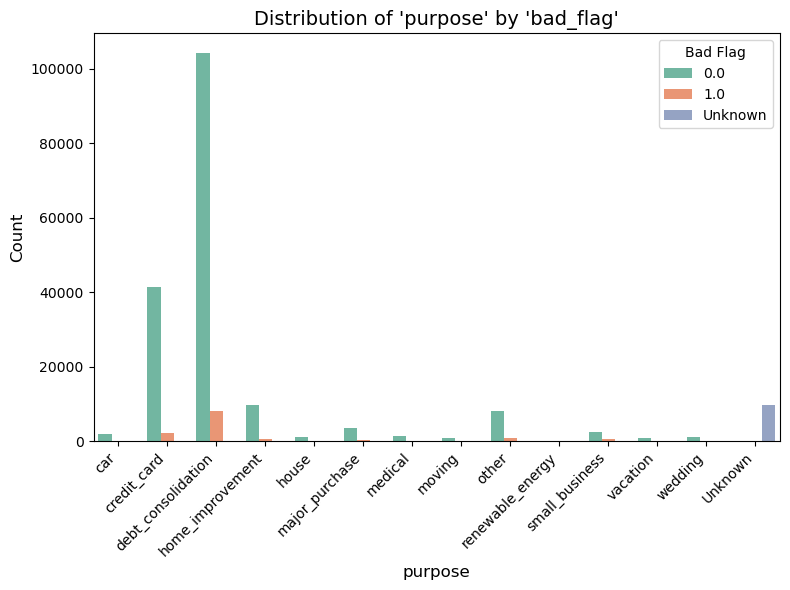

In [22]:
categorical_columns = train_data_cleaned.select_dtypes(include=['category']).columns

# Plot distributions for each categorical column
for col in categorical_columns:
    if col == 'bad_flag':  # Skip plotting for 'bad_flag'
        continue
    
    plt.figure(figsize=(8, 6))
    
    # Plot distribution with normalization for clearer comparison
    sns.countplot(
        data=train_data_cleaned, x=col, hue='bad_flag', palette='Set2'
    )
    
    # Add title and labels
    plt.title(f"Distribution of '{col}' by 'bad_flag'", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Bad Flag', loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

1. **Distribution of 'term' by 'bad_flag'**:  
   - Loans with a **36-month term** dominate the dataset across all `bad_flag` categories.  
   - Loans with a **60-month term** have a higher proportion of bad loans (`bad_flag = 1.0`), suggesting that longer-term loans may be riskier.  
   - Loans with **Unknown terms** are minimal and may require further cleaning.

2. **Distribution of 'home_ownership' by 'bad_flag'**:  
   - The majority of borrowers either **rent** or have a **mortgage**.  
   - Borrowers who own homes (`OWN`) are fewer, but their proportion of bad loans is similar to renters and mortgage holders.  
   - **Unknown home ownership** represents a small segment and may need additional handling.

3. **Distribution of 'purpose' by 'bad_flag'**:  
   - **Debt consolidation** is the most common loan purpose, followed by **credit card repayment** and **home improvement**.  
   - A slightly higher proportion of bad loans is observed for debt consolidation and credit card purposes compared to other categories.  
   - Loan purposes like **vacation**, **wedding**, and **renewable energy** are rare but still show some bad loans.

# Handle Outliers in Numeric Features

In [23]:
def handle_outliers(df, columns, lower_q=0.01, upper_q=0.99, log_changes=False):
    """
    Handles outliers by clipping values outside the specified quantiles.

    Parameters:
        df (pd.DataFrame): DataFrame to process.
        columns (list): List of column names to handle outliers for.
        lower_q (float): Lower quantile threshold (default 0.01).
        upper_q (float): Upper quantile threshold (default 0.99).
        log_changes (bool): Whether to log the number of clipped values per column.

    Returns:
        pd.DataFrame: DataFrame with outliers handled.
    """
    for col in columns:
        if col in df.columns:
            lower_bound = df[col].quantile(lower_q)
            upper_bound = df[col].quantile(upper_q)
            if log_changes:
                clipped_values = (df[col] < lower_bound) | (df[col] > upper_bound)
                print(f"Clipped {clipped_values.sum()} outliers in column '{col}'")
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Preprocess and handle outliers
numeric_columns = train_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
train_data_no_outliers = handle_outliers(train_data_cleaned.copy(), numeric_columns, log_changes=True)

# Summary statistics after handling outliers
summary_after_outliers = train_data_no_outliers.describe()

# Display the summary statistics
summary_after_outliers

Clipped 1800 outliers in column 'loan_amnt'
Clipped 1875 outliers in column 'int_rate'
Clipped 0 outliers in column 'emp_length'
Clipped 3825 outliers in column 'annual_inc'
Clipped 0 outliers in column 'percent_bc_gt_75'
Clipped 3924 outliers in column 'bc_util'
Clipped 3961 outliers in column 'dti'
Clipped 1141 outliers in column 'inq_last_6mths'
Clipped 709 outliers in column 'mths_since_recent_inq'
Clipped 3917 outliers in column 'revol_util'
Clipped 3796 outliers in column 'total_bc_limit'
Clipped 3984 outliers in column 'tot_hi_cred_lim'
Clipped 3984 outliers in column 'tot_cur_bal'
Clipped 1800 outliers in column 'internal_score'


1,loan_amnt,int_rate,emp_length,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score
count,199121.000000,199121.000000,181531.00000,199121.000000,199121.000000,199121.000000,199121.000000,199121.000000,199121.000000,199121.000000,199121.00000,199121.000000,199121.000000,199121.000000
mean,14075.293289,14.266108,6.09215,70676.185730,53.239957,70.078422,17.049544,0.756831,6.802201,58.498120,19521.46198,19507.660101,124695.769510,184.011571
std,8061.800813,4.311175,3.56594,36704.972101,32.527210,9.725225,7.377479,0.991435,5.297818,22.356772,16726.49293,16748.381841,124632.164957,104.789578
min,1600.000000,6.030000,0.00000,20000.000000,0.000000,21.500000,1.970000,0.000000,0.000000,3.000000,500.00000,483.440342,4094.200000,22.000000
25%,8000.000000,11.140000,3.00000,45500.000000,33.300000,70.700000,11.650000,0.000000,3.000000,43.600000,8400.00000,8373.857706,33713.000000,105.000000
50%,12000.000000,14.090000,6.00000,62000.000000,50.000000,70.700000,16.780000,0.000000,6.000000,60.500000,14700.00000,14637.479485,80760.500000,157.000000
75%,19600.000000,17.270000,10.00000,85000.000000,80.000000,70.700000,22.230000,1.000000,9.000000,75.700000,24900.00000,24879.507590,178262.000000,256.000000
max,35000.000000,24.500000,10.00000,225000.000000,100.000000,98.000000,33.600000,4.000000,23.000000,97.100000,89500.00000,89342.027744,606330.400000,456.000000


# Remove highly correlated features

Removed features due to high correlation: ['tot_hi_cred_lim', 'internal_score']


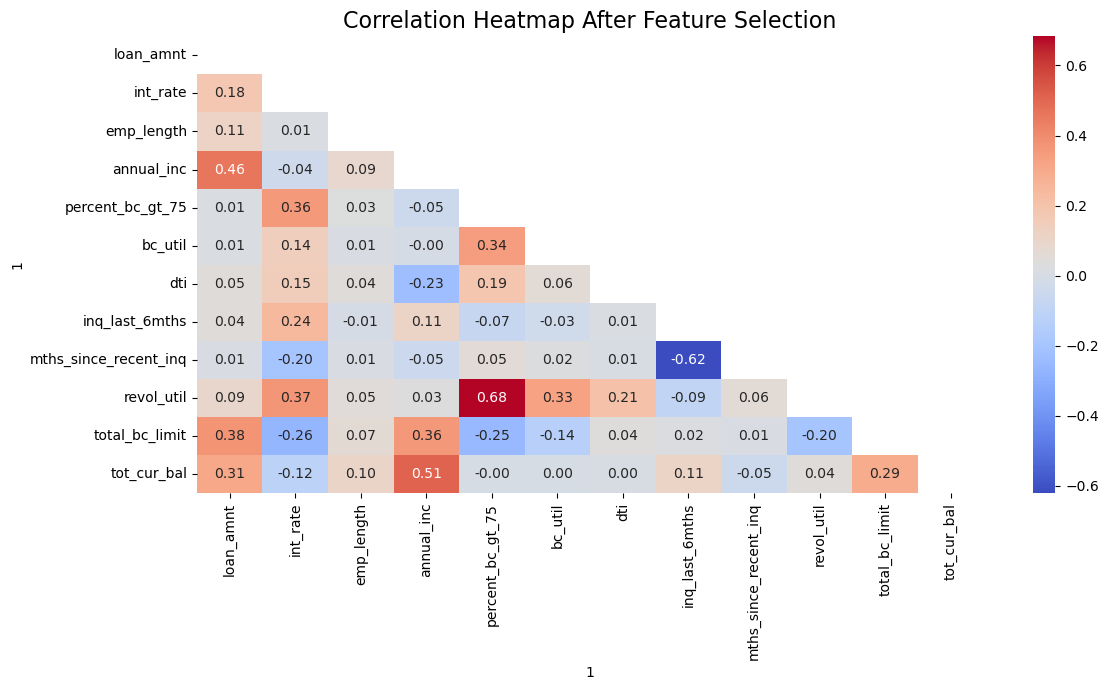

In [24]:
# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    """
    Removes features with a correlation coefficient greater than the specified threshold.

    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric features.
        threshold (float): Correlation coefficient threshold (default 0.9).

    Returns:
        pd.DataFrame: DataFrame with highly correlated features removed.
        list: List of removed feature names.
    """
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(columns=to_drop, errors='ignore'), to_drop

# Apply feature selection
train_data_selected, removed_features = remove_highly_correlated_features(
    train_data_no_outliers.select_dtypes(include=['float64', 'int64'])
)

# Log removed features
print(f"Removed features due to high correlation: {removed_features}")

# Correlation heatmap after feature selection
plt.figure(figsize=(12, 7))
mask = np.triu(np.ones_like(train_data_selected.corr(), dtype=bool))
sns.heatmap(train_data_selected.corr(), mask=mask, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap After Feature Selection", fontsize=16)
plt.tight_layout()
plt.show()

# Handle Unknowns in Data

In [25]:
def clean_unknowns(df):
    """
    Handles 'Unknown' values in categorical columns of the dataset reliably using .loc.
    
    Parameters:
        df (pd.DataFrame): The dataset to process.
    
    Returns:
        pd.DataFrame: The cleaned dataset.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['category']).columns

    # Handle 'Unknown' values
    for col in categorical_columns:
        if 'Unknown' in df[col].cat.categories:
            print(f"Handling 'Unknown' in column: {col}")
            
            # Drop rows with 'Unknown'
            df = df[df[col] != 'Unknown'].copy()
            
            # Drop 'Unknown' from categories
            df[col] = df[col].cat.remove_categories(['Unknown'])

    return df

# Reapply the updated cleaning function to the training dataset
train_data_cleaned_final = clean_unknowns(train_data_no_outliers)

# Verify the cleaned dataset
print("After Rechecking 'Unknown':")
for col in train_data_cleaned.select_dtypes(include=['category']).columns:
    print(f"Unique values in {col}: {train_data_cleaned_final[col].unique()}")

Handling 'Unknown' in column: term
Handling 'Unknown' in column: home_ownership
Handling 'Unknown' in column: purpose
Handling 'Unknown' in column: bad_flag
After Rechecking 'Unknown':
Unique values in term: [' 36 months', ' 60 months']
Categories (2, object): [' 36 months', ' 60 months']
Unique values in home_ownership: ['RENT', 'OWN', 'MORTGAGE', 'NONE', 'OTHER']
Categories (5, object): ['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']
Unique values in purpose: ['debt_consolidation', 'home_improvement', 'credit_card', 'other', 'major_purchase', ..., 'medical', 'car', 'vacation', 'renewable_energy', 'wedding']
Length: 13
Categories (13, object): ['car', 'credit_card', 'debt_consolidation', 'home_improvement', ..., 'renewable_energy', 'small_business', 'vacation', 'wedding']
Unique values in bad_flag: [0.0, 1.0]
Categories (2, object): [0.0, 1.0]


In [26]:
train_data_cleaned_final.head()

1,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag
0,7550,36 months,16.24,3.0,RENT,28000.0,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72.0,4000.0,3828.953801,5759.0,99,0.0
1,27050,36 months,10.99,10.0,OWN,55000.0,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.2,35700.0,34359.940730,114834.0,353,0.0
2,12000,36 months,10.99,4.0,RENT,60000.0,debt_consolidation,0.0,21.5,4.62,1.0,3.0,24.0,18100.0,16416.617760,7137.0,157,0.0
3,28000,36 months,7.62,5.0,MORTGAGE,225000.0,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.6,42200.0,38014.149760,606330.4,365,0.0
4,12000,36 months,13.53,10.0,RENT,40000.0,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.8,7000.0,6471.462236,13605.0,157,0.0


# Handle Class Imbalance

In [27]:
# Define feature matrix (X) and target vector (y)
X= train_data_cleaned_final.drop(columns=['bad_flag'])
y = train_data_cleaned_final['bad_flag']

## Handle missing values

In [29]:
# Handle missing values before applying SMOTE
# Fill numeric columns with the median
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

# Hncoding of categorical features

In [30]:
# Encode categorical features and ensure no missing values in encoded data
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
if not categorical_columns.empty:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_categorical = pd.DataFrame(
        encoder.fit_transform(X[categorical_columns]),
        columns=encoder.get_feature_names_out(categorical_columns)
    )
    X = X.drop(columns=categorical_columns).reset_index(drop=True)
    X = pd.concat([X, encoded_categorical], axis=1)


In [31]:
if y.dtypes == 'category':
    print("Converting 'category' dtype in target variable to integer codes.")
    y = y.cat.codes  # Converts categories to integer codes

Converting 'category' dtype in target variable to integer codes.


In [33]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [34]:
# Check class distribution
print("Class Distribution After SMOTE:")
print(y_balanced.value_counts())

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}, Validation Data Shape: {X_val.shape}")

Class Distribution After SMOTE:
0    176329
1    176329
Name: count, dtype: int64
Training Data Shape: (282126, 31), Validation Data Shape: (70532, 31)


In [35]:
# Check unique values in the `bad_flag` column
print("Unique values in 'bad_flag' before SMOTE:", y.unique())

Unique values in 'bad_flag' before SMOTE: [0 1]


# Feature Scaling

In [37]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform training and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# (Optional) Transform the test dataset once it's preprocessed
# test_data_scaled = scaler.transform(test_data_encoded)

# Convert scaled data back to DataFrames for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

# Verify scaled training data
print("Scaled Training Data - Mean (approx 0):", X_train_scaled.mean(axis=0))
print("Scaled Training Data - Std Dev (approx 1):", X_train_scaledstd(axis=0))

Scaled Training Data - Mean (approx 0): [ 2.43793684e-17 -9.26818963e-17  8.93322517e-17  9.03144783e-17
 -2.50341861e-16  1.20092315e-15  5.85451139e-16  1.04342689e-16
  4.79710666e-16  2.86961284e-16 -6.28625036e-17  7.53544113e-17
  6.07847165e-17  9.85248854e-17  8.64989057e-17  8.48744540e-18
 -1.32474667e-17  3.69468320e-17 -2.11027611e-16 -6.51291804e-17
  2.67845643e-16  4.02461061e-17  3.22371813e-18  2.78864211e-17
 -3.14816224e-17 -2.16341709e-17 -2.26163975e-17  1.66222966e-18
  3.66697938e-17 -3.35216315e-17 -7.58077467e-18]
Scaled Training Data - Std Dev (approx 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


# Neural Network

In [38]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create PyTorch DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define the Neural Network
class LoanPredictionNN(nn.Module):
    def __init__(self, input_dim):
        super(LoanPredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model
input_dim = X_train_scaled.shape[1]
model = LoanPredictionNN(input_dim).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu
